Looking at legal documents is always funny to me. I love seeing the precise, exact language that they use in all of the documents. It sounds like a robot wrote it, nothing that a human could possibly make.

That got me wondering, how exact IS the language? They must use the same 20 words over 80% of the time. Words like court, state, plaintiff, all staples in this type of language.

The good news is we live in the world of the internet and python, and python libraries. Meaning that actually pulling the data and looking through hundreds of court cases is not only possible, it is pretty easy.

The process of this is pretty simply. The first step is to actually get the court cases. The main place I will be getting my cases from is google scholar. They have a court case searching page for federal and state courts. I will be focusing on federal courts for this, but it is entirely possible to do state courts as well.

To get the court cases, we will set up a python script to do a few things. It will search google scholar for court cases based off a random term you provice, or a name. It will then grab these cases as an HTML file, and scrap out all the HTML garbage we don't need, and just give us the juicy text. Let's begin:

In [1]:
# A few imports wil be needed for this.



# OS is great for saving files in your computer, which I will be doing with these cases.
import os

# Requests is how python communicates with google scholar and gets the HTML pages.
import requests

# Re is for regex, which is needed to remove all the punctuation and other garbage
import re

# Textmining, because it can make a DTM very easily, dead simply in fact.
import textmining

# Beautifulsoup takes an HTML page and returns only the text, none of the HTML trash.
from bs4 import BeautifulSoup

# URLJoin and Parse are both useful tools for manipulating URLS
from urllib.parse import urljoin, urlparse

# Optional imports incase you are getting blocked by google
# import time
# import random

Looping and parsing through hundreds of web pages really has a unique way of setting off google's anti-scraper detection.
There's a few ways to get around this. I added a useragent so my requests look more 'Human'

In [2]:
# Tricks the webpage into thinking i'm just an innocent chrome user
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/111.0.0.0 Safari/537.36'}

Great. Now that we have our disguise, let's get some functions set up for processing the web pages.

In [3]:
# Provide the name for the text file. "Party A v. Party B.txt". Super nice and readable
def SimplifyCaseTitle(case_title):
    simplified_title = re.sub(r',\s\d+.*$', '', case_title)
    if len(simplified_title) > 128:
        return simplified_title[:128-3] + '..'
    else:
        return simplified_title

In [4]:
# Remove things like page breaks
def RemoveGarbage(DirtyString):
    cleaned_text = re.sub(r'\s+', ' ', DirtyString)
    return cleaned_text.strip()

In [5]:
# Send text to a text document in Output
def OutputText(text):
    FileName = SimplifyCaseTitle(text[0:300]) + ".txt"
    FileName = FileName.replace("\\", "")
    outputFolderPath = os.path.join(os.getcwd(), 'Output')
    if not os.path.exists(outputFolderPath):
        os.makedirs(outputFolderPath)
    filePath = os.path.join(outputFolderPath, FileName)
    with open(filePath, 'w', encoding='utf-8') as file:
        file.write(text)

In [6]:
# Takes info like # of pages, search query, and other URL information, and builds a nice URL with it
def GenerateBaseURL(SearchQuery, Page):
    SearchQuery = SearchQuery.replace(' ', '+')
    StartOn = (Page - 1) * 10
    return ScholarURL + PreStart + str(StartOn) + PreQuery + SearchQuery + PostQuery

In [7]:
# Find links on page and put them into a nice little list
# Great for looking through search results and finding the articles.
def GetLinksFromPage(ParsedHTML):
    PageLinks = set()
    for link in ParsedHTML.find_all('a', href=True):
        full_url = urljoin(ScholarURL, link['href']) # HREF is the HTML tag for a link
        if urlparse(full_url).netloc == urlparse(ScholarURL).netloc:
            lowerURL = full_url.lower()
            IsGoodPage = 'scholar_case?case=' in lowerURL # we ONLY want other articles. None of the other links
            if IsGoodPage:
                PageLinks.add(full_url)
    return PageLinks

Now that our functions are up and running, we can start with the main logic.
We need a link for our requests library to work with. If you go into the google scholar website, you'll notice the links follow a structure
For example:

https://scholar.google.com/scholar?start=0&q=Nvidia&hl=en&as_sdt=8000003

https://scholar.google.com  |  /scholar?start=  |  0  |  &q=  |  Nvidia  |  &hl=en&as_sdt=8000006

All we have to do is replace the number and 'Nvidia' with the # of the page, and the desired search term.

In [8]:
# Parts of the URL we will be manipulating.
ScholarURL = "https://scholar.google.com"
PreStart   = "/scholar?start="
PreQuery   = "&q="
PostQuery  = "&hl=en&as_sdt=8000006"

Now we can choose our search topic, and the number of pages we want to search.

In [9]:
# What you're searching for on the website
SearchQuery = "SpaceX"

# How many pages to parse? 1 page is 10 text documents.
HowManyPagesToParse = 2

Great. We have all the pieces of the puzzle. Let's start scraping.

In [10]:
# This is how many documents we will be copying.
TotalDocuments = 10 * HowManyPagesToParse


CurrentDocument = 1
for i in range(HowManyPagesToParse):
    # Go through the search results and find every individual case.
    ParseTestURL = GenerateBaseURL(SearchQuery, i + 1)
    BaseSearchPage = requests.get(ParseTestURL, headers=headers)
    BaseSearchParse = BeautifulSoup(BaseSearchPage.text, 'html.parser')
    print("BASE URL: " + ParseTestURL)
    URLS = GetLinksFromPage(BaseSearchParse)

    
    for url in URLS:
        # Optional waiting period to avoid getting your IP blocked by scraping detectors.
        # time.sleep(random.randint(4, 8))
        
        # Go through every link on the search results, get text, and dump it into a file in the 'Output' folder
        Requested = requests.get(url, headers=headers)
        Parsed = BeautifulSoup(Requested.text, 'html.parser')
        for ScriptOrStyle in Parsed(["script", "style"]):
            ScriptOrStyle.decompose()
        TextFragments = [Element.get_text() for Element in Parsed.find_all(['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'])]
        CleanText = ' '.join(TextFragment.strip() for TextFragment in TextFragments)
        CleanText = RemoveGarbage(CleanText)
        print("(" + str(CurrentDocument) + "/" + str(TotalDocuments) + ") " + SimplifyCaseTitle(CleanText[0:300]) + ".txt")
        OutputText(CleanText)
        CurrentDocument += 1

BASE URL: https://scholar.google.com/scholar?start=0&q=SpaceX&hl=en&as_sdt=8000006
(1/20) Phoenix Mechanical Pipeline, Inc. v. Space Exploration Technologies Corp..txt
(2/20) McMillan v. HOLSTROM, BLOCK & PARKE, APLC, Cal: Court of Appeal.txt
(3/20) TWITTER, INC. v. MUSK, Del: Court of Chancery 2022 TWITTER, INC., Plaintiff and Counterclaim-Defendant, v. ELON R. MUSK, X HO...txt
(4/20) Little v. Washington Metropolitan Area Transit Authority, Dist. Court, Dist. of Columbia 2017 ERICK LITTLE, et al., Plaintiff...txt
(5/20) Viasat, Inc. v. FEDERAL COMMUNICATIONS COM'N.txt
(6/20) In re Tesla, Inc. Securities Litigation.txt
(7/20) CUHACI v. KOURI GROUP, LP, Dist. Court, SD Florida 2020 MARK CUHACI, Plaintiff, v. KOURI GROUP, LP, et al., Defendants. Unite...txt
(8/20) CUHACI v. KOURI GROUP, LP, Dist. Court, SD Florida 2021 MARK CUHACI, Plaintiff, v. KOURI GROUP, LP, et al., Defendants. Unite...txt
(9/20) Motor Vehicle Mfrs. Assn. of United States, Inc. v. State Farm Mut. Automobile Ins. Co.

You may notice that this works very well for the first ~4 pages. After that, it stops getting the pages. Why?
Well. Google is onto us, and they've blocked our IP. Bummer.
My admittedly unscientific solution to this problem was to just use a VPN to switch my IP to a different location, and repeat the process.
If you don't have access to such luxuries, you could add a

time.sleep(random.randint(4, 8))

between each URL, so you aren't hitting the servers as hard.

---------------------------------------------------------------------------------------------
Aside from that, we now have hundreds of court cases at our fingertips for data analysis.
There's so much we can do with this that I couldn't possibly list it all in a jupyter notebook.
Let's start with something basic like a document-term-matrix. We'll see what terms appear and how often they appear.

In [11]:
# Let's start with a few needed imports.

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import nltk

In [12]:
# Function to preprocess text
def PreprocessText(Text):
    Text = Text.lower()
    Text = Text.translate(str.maketrans('', '', string.punctuation))
    Tokens = Text.split()
    StopWords = set(stopwords.words('english'))
    Tokens = [Word for Word in Tokens if Word not in StopWords]
    Stemmer = PorterStemmer()
    Tokens = [Stemmer.stem(Word) for Word in Tokens]
    PreprocessedText = ' '.join(Tokens)
    return PreprocessedText

In [13]:
# Function to create Document-Term Matrix
def CreateDocumentTermMatrix(DirectoryPath):
    Documents = []
    FileNames = []
    
    for FileName in os.listdir(DirectoryPath):
        if FileName.endswith('.txt'):
            FilePath = os.path.join(DirectoryPath, FileName)
            with open(FilePath, 'r', encoding='utf-8') as File:
                Text = File.read()
                PreprocessedText = PreprocessText(Text)
                Documents.append(PreprocessedText)
                FileNames.append(FileName)
    
    Vectorizer = CountVectorizer()
    DTMatrix = Vectorizer.fit_transform(Documents)
    DTMDataFrame = pd.DataFrame(DTMatrix.toarray(), index=FileNames, columns=Vectorizer.get_feature_names_out())
    
    return DTMDataFrame

In [14]:

# Function to print the most common words
def PrintMostCommonWords(DTMDataFrame, NumberOfWords=10):
    WordSums = DTMDataFrame.sum(axis=0)
    SortedWords = WordSums.sort_values(ascending=False)
    
    # Print the most common words
    print(f"Top {NumberOfWords} most common words:")
    for Word, Frequency in SortedWords.head(NumberOfWords).iteritems():
        print(f"{Word}: {Frequency}")

In [15]:
# We'll use this to create plots to show off information
import matplotlib.pyplot as plt

DirectoryPath = 'Output'  # Update this if your folder is elsewhere
DTM = CreateDocumentTermMatrix(DirectoryPath)

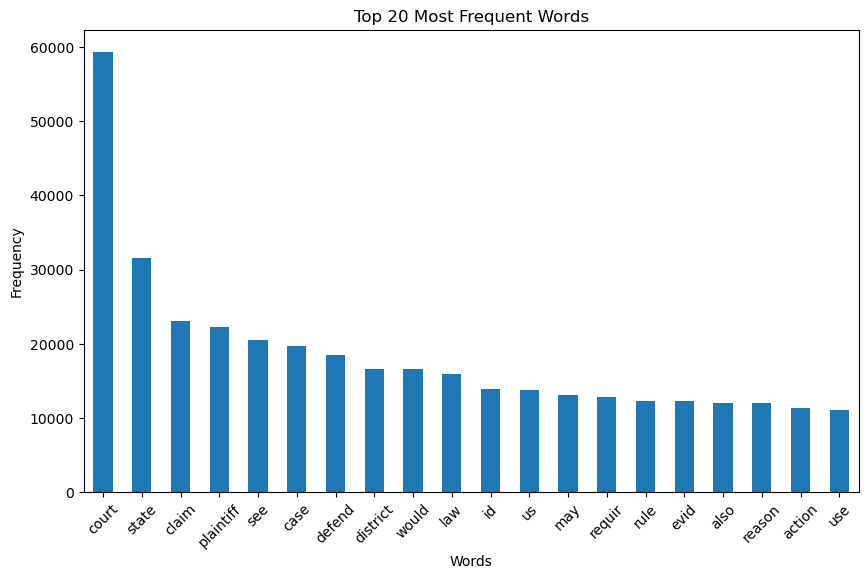

In [16]:
word_frequencies = DTM.sum(axis=0).sort_values(ascending=False)

# Plot the top N most frequent words
top_n = 20
word_frequencies.head(top_n).plot(kind='bar', figsize=(10, 6))
plt.title(f'Top {top_n} Most Frequent Words')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.show()

Absolutely beautiful. Just like I thought, words like 'court' 'state' 'plaintiff' are at the front. This makes sense because courts use a very standardized set of language.